# Introduction to DEA Mangroves <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_mangrove_cover_cyear_3](https://explorer.dea.ga.gov.au/products/ga_ls_mangrove_cover_cyear_3)

## Background

Mangroves are unique, valuable and vulnerable woody plant species that inhabit intertidal regions around much of the Australian coastline.

They provide a diverse array of ecosystem services such as:

* coastal protection
* carbon storage
* nursery grounds and habitat for a huge variety of avian, coastal and marine animal species.

However, mangrove ecosystems are impacted upon by both natural and anthropogenic drivers of change such as sea-level rise, coastal land reclaimation and severe tropical cyclone damage.
In Australia, mangroves are protected by law and consequently, changes in their extent and canopy density are driven predominantly by natural drivers.

Modelling mangrove canopy density offers an effective mechanism to assess how mangroves are responding to these external influences and to monitor their recovery to ensure that they can continue to thrive and support our vital coastal ecosystems.

## Description

The [DEA Mangroves](https://cmi.ga.gov.au/data-products/dea/634/dea-mangrove-canopy-cover-landsat) data product maps the annual canopy cover density of Australian mangroves within a fixed extent around the entire continental coastline. 
The extent represents a union of [Global Mangrove Watch layers](https://data.unep-wcmc.org/datasets/45) for multiple years, produced by the Japanese Aerospace Exploration Agency.

Within this extent, mangroves are identified by leveraging a relationship between the 10th percentile green vegetation component of the DEA [Fractional Cover](https://cmi.ga.gov.au/data-products/dea/629/dea-fractional-cover-landsat) data product with Light Detection And Ranging (LiDAR)-derived Planimetric Canopy Cover% (PCC).
More detail on the method can be found [here](https://www.sciencedirect.com/science/article/pii/S0034425719301890?via%3Dihub).

Three cover classes are identified within the product which are defined as:

* Closed Forest -  pixels with more than 80 % mangrove canopy cover
* Open Forest - pixels with between 50 % and 80 % canopy cover
* Woodland - pixels with between 20 % and 50 % canopy cover

This notebook introduces the DEA Mangroves data product and steps through how to:

1. View the product name and associated measurements in the DEA database
2. Load the dataset and view the data classes within it
3. Plot a single timestep image
4. Create and view an animation of the whole timeseries
5. Plot change over time by graphing the timeseries of each class
6. Identify hotspot change areas within each class

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import xarray as xr
from datacube.utils import masking
from IPython.core.display import Video
from matplotlib.colors import LinearSegmentedColormap

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.plotting import display_map, xr_animation

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="DEA_Mangroves")

### View the DEA Mangroves product and measurements list

View the official DEA Mangroves product name, description and licensing details

In [3]:
dc_products = dc.list_products()
dc_products.loc[["ga_ls_mangrove_cover_cyear_3"]]

,name,description,license,default_crs,default_resolution
name,,,,,
ga_ls_mangrove_cover_cyear_3,ga_ls_mangrove_cover_cyear_3,Geoscience Australia Landsat Mangrove Cover Ca...,CC-BY-4.0,None,None


View the list of measurements associated with the DEA Mangroves product.
Note the single measurement unit, the nodata value and the flags_definitions.

In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[["ga_ls_mangrove_cover_cyear_3"]]

,,name,dtype,units,nodata,aliases,flags_definition
product,measurement,,,,,,
ga_ls_mangrove_cover_cyear_3,canopy_cover_class,canopy_cover_class,uint8,1,255,NaN,"{'woodland': {'bits': [0, 1, 2, 3, 4, 5, 6, 7]..."


## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
Zoom around the displayed map to understand the context of the analysis area.
To select a new area, click on the map to reveal the Latitude (`y`) and Longitude (`x`) for diagonally opposite corners and place these values into the `query`

Replace the `y` and `x` coordinates to try the following locations:

* Bowling Green Bay, Qld
    * "y": (-19.50688750115376, -19.27501266742088)
    * "x": (147.05183029174404, 147.47617721557216)
* Pellew Islands, NT
    * "y": (-15.6786, -16.0075)
    * "x": (136.5360, 137.0682)

In [5]:
# Set up a region to load data
query = {
    "y": (-15.6786, -16.0075),
    "x": (136.5360, 137.0682),
    "time": ("1988", "2022"),
}
display_map(x=query["x"], y=query["y"])

## Load and view DEA Mangroves

In [6]:
# Load data from the DEA datacube catalogue
mangroves = dc.load(product="ga_ls_mangrove_cover_cyear_3", **query)
mangroves

<xarray.Dataset>
Dimensions:             (time: 35, y: 1277, x: 1957)
Coordinates:
  * time                (time) datetime64[ns] 1988-07-01T23:59:59.999999 ... ...
  * y                   (y) float64 -1.675e+06 -1.675e+06 ... -1.713e+06
  * x                   (x) float64 4.881e+05 4.881e+05 ... 5.467e+05 5.468e+05
    spatial_ref         int32 3577
Data variables:
    canopy_cover_class  (time, y, x) uint8 255 255 255 255 ... 255 255 255 255
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### View the DEA Mangroves class values and definitons

In [7]:
# Extract the flags information from the dataset
flags = masking.describe_variable_flags(mangroves)
flags["bits"] = flags["bits"].astype(str)
flags = flags.sort_values(by="bits")

# Append the class descriptions to each class
descriptors = {
    "closed_forest": "> 80 % canopy cover",
    "open_forest": "50 - 80 % canopy cover",
    "woodland": "20 - 50 % canopy cover",
    "notobserved": "Fewer than 3 clear observations",
}
flags = flags.rename(columns={"description": "class"})
flags["description"] = pd.Series(data=descriptors, index=flags.index)

# View the values in the dataset that are associated with each class
flags

,bits,values,class,description
woodland,"[0, 1, 2, 3, 4, 5, 6, 7]",{'1': True},Woodland,20 - 50 % canopy cover
notobserved,"[0, 1, 2, 3, 4, 5, 6, 7]",{'0': True},Mangroves not observed,Fewer than 3 clear observations
open_forest,"[0, 1, 2, 3, 4, 5, 6, 7]",{'2': True},Open Forest,50 - 80 % canopy cover
closed_forest,"[0, 1, 2, 3, 4, 5, 6, 7]",{'3': True},Closed Forest,> 80 % canopy cover


## Plot a single timestep

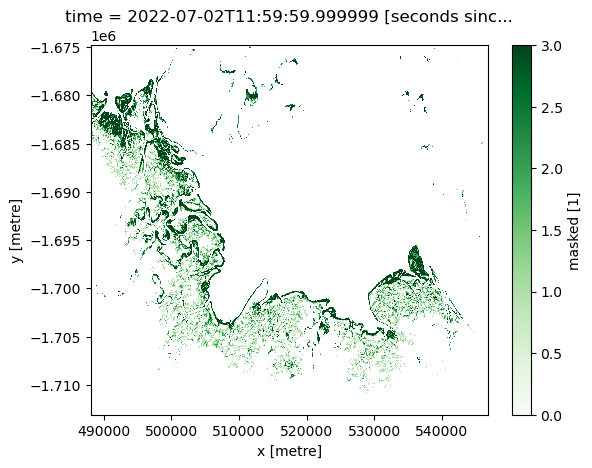

In [8]:
# Firstly, mask out the nodata values
mangroves["masked"] = mangroves.canopy_cover_class.where(mangroves.canopy_cover_class != 255)

# Plot the most recent timestep
mangroves["masked"].isel(time=-1).plot(cmap="Greens")

## View all timesteps as an animation

In [9]:
# Produce time series animation of RGB
xr_animation(
    ds=mangroves,
    bands=["masked"],
    output_path="DEA_Mangroves.mp4",
    annotation_kwargs={"fontsize": 20, "color": "white"},
    show_date="%Y",
    imshow_kwargs={"cmap": "Greens"},
    show_colorbar=True,
    interval=1000,
    width_pixels=800,
)

# Plot animation
plt.close()

# View and interact with the animation
Video("DEA_Mangroves.mp4", embed=True)

Exporting animation to DEA_Mangroves.mp4


  0%|          | 0/35 (0.0 seconds remaining at ? frames/s)

## Plot the area (number of pixels) occupied by each class at every timestep in the area of interest

If you want to include the `not_observed` pixels in the following analysis, remove the `# ` from the start of the 4 code lines below that relate to that class

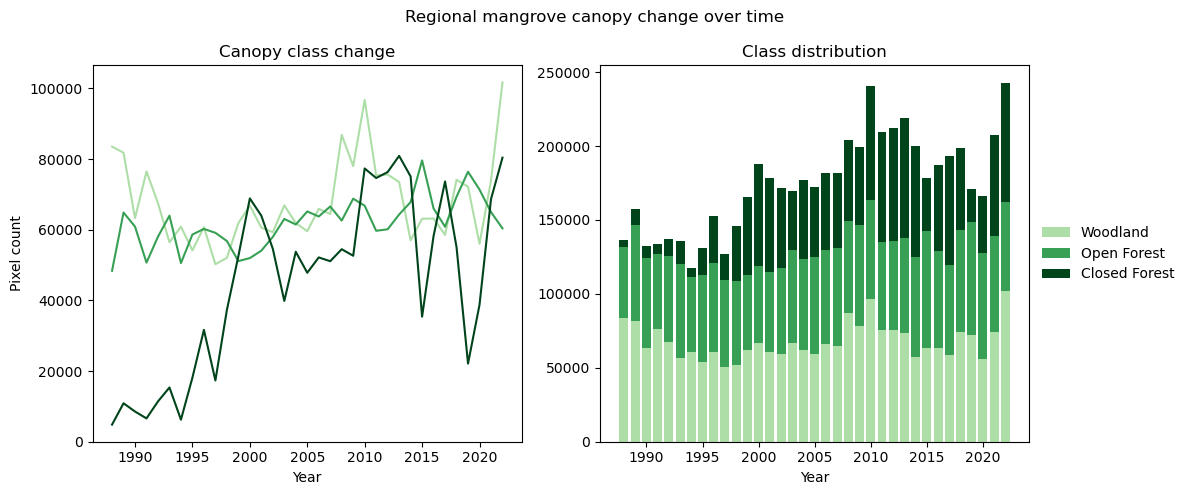

In [10]:
# Set up the data for plotting: count the number of pixels per class in the loaded location
mangroves["closed_forest"]= mangroves.canopy_cover_class.where(mangroves.canopy_cover_class == 3)
mangroves["open_forest"] = mangroves.canopy_cover_class.where(mangroves.canopy_cover_class == 2)
mangroves["woodland"] = mangroves.canopy_cover_class.where(mangroves.canopy_cover_class == 1)
# mangroves["not_observed"] = mangroves.canopy_cover_class.where(mangroves.canopy_cover_class == 0)

y1 = mangroves["woodland"].count(dim=["y", "x"])
y2 = mangroves["open_forest"].count(dim=["y", "x"])
y3 = mangroves["closed_forest"].count(dim=["y", "x"])
# y4 = mangroves["not_observed"].count(dim=["y", "x"])

# Simplify the date labels for the x-axis
x = np.arange(int(query["time"][0]), int(query["time"][-1]) + 1, 1)

# Prepare the figures
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Regional mangrove canopy change over time")

# Plot the single class summaries
axs[0].plot(x, y1, color="#aedea7", label="Woodland")
axs[0].plot(x, y2, color="#37a055", label="Open Forest")
axs[0].plot(x, y3, color="#00441b", label="Closed Forest")
# axs[0].plot(x, y4, color="black", label="Not observed")
axs[0].set_title("Canopy class change")
axs[0].set(ylabel="Pixel count", xlabel="Year")

# Stack the classes to plot a snapshot of the region at each time step
axs[1].bar(x, y1, color="#aedea7", label="Woodland")
axs[1].bar(x, y2, color="#37a055", label="Open Forest", bottom=y1)
axs[1].bar(x, y3, color="#00441b", label="Closed Forest", bottom=(y1 + y2))
# axs[1].bar(x, y4, color="black", label="Not observed", bottom=(y1 + y2 + y3))
axs[1].legend(bbox_to_anchor=(1.0, 0.5), loc="center left", frameon=False)
axs[1].set_title("Class distribution")
axs[1].set(xlabel="Year")

plt.tight_layout()
plt.show()

## Detect change hotspots in each class

Identify change hotspots in the analysis area by assessing the frequency that each class was identified during the length of the timeseries.

Green areas signify pixels that have a high frequency of being identified as the class of interest over the length of the timeseries and were consistently modelled as that class.
Orange to red areas are pixels that were less frequently identified as the class of interest during the timeseries and thus, experienced change between classes during the timeseries.

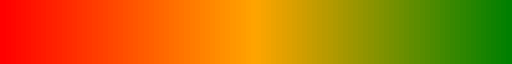

In [11]:
# Create and view a custom colormap (ignore the `under`, `bad` and `over` categories)
cmap = LinearSegmentedColormap.from_list("rg", ["r", "orange", "g"], N=100)
cmap

Text(0.5, 1.0, 'Closed forest frequency (%)')

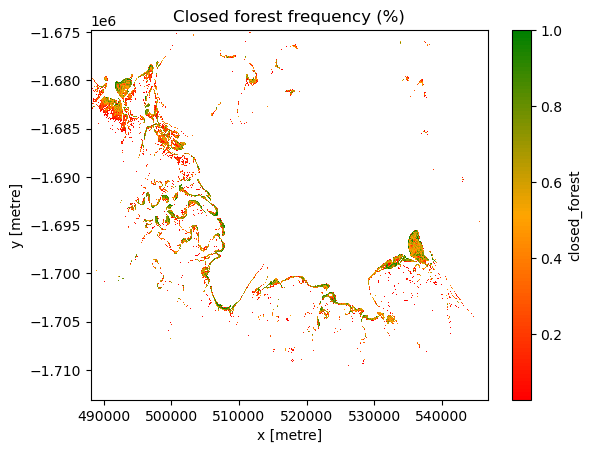

In [12]:
# Create a boolean mask of the `Closed Forest` class
mangroves["closed_forest"] = masking.make_mask(mangroves.canopy_cover_class, closed_forest=True)
# Calculate the frequency of each pixel being identified as `Closed Forest` during the timeseries
mg_cf = mangroves["closed_forest"].mean(dim=["time"])
# Mask out values of 0 to ensure a clean visualisation
mg_cf.where(mg_cf > 0).plot(cmap=cmap)
# Title the plot
plt.title("Closed forest frequency (%)")

Text(0.5, 1.0, 'Open forest frequency (%)')

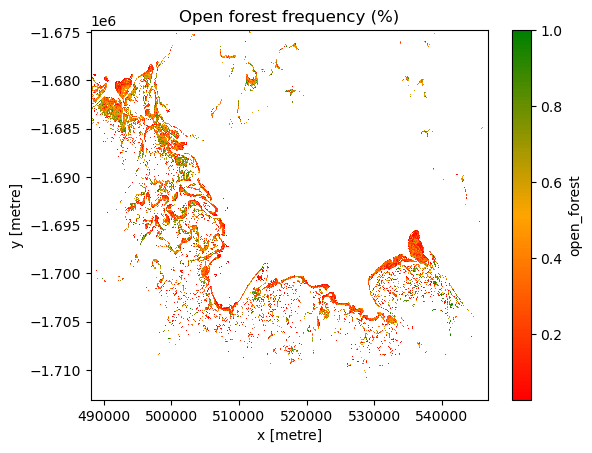

In [13]:
# Create a boolean mask of the `Open Forest' class
mangroves["open_forest"] = masking.make_mask(mangroves.canopy_cover_class, open_forest=True)
# Calculate the frequency of each pixel being identified as `Open Forest` during the timeseries
mg_of = mangroves["open_forest"].mean(dim=["time"])
# Mask out values of 0 to ensure a clean visualisation
mg_of.where(mg_of > 0).plot(cmap=cmap)
# Title the plot
plt.title("Open forest frequency (%)")

Text(0.5, 1.0, 'Woodland frequency (%)')

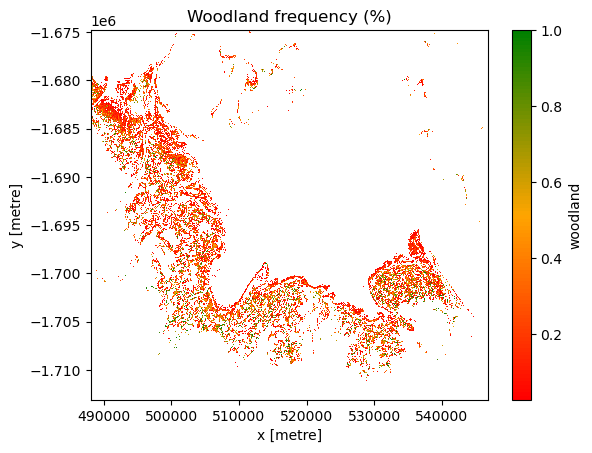

In [14]:
# Create a boolean mask of the `Woodland' class
mangroves["woodland"] = masking.make_mask(mangroves.canopy_cover_class, woodland=True)
# Calculate the frequency of each pixel being identified as `Woodland` during the timeseries
mg_wl = mangroves["woodland"].mean(dim=["time"])
# Mask out values of 0 to ensure a clean visualisation
mg_wl.where(mg_wl > 0).plot(cmap=cmap)
# Title the plot
plt.title("Woodland frequency (%)")

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2023

**Compatible datacube version:** 1.8.13

In [15]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)